In [ ]:
from google.colab import drive
import os.path

path = '/content/drive'

if os.path.ismount(path) == False:
  drive.mount(path)


In [ ]:
%cd "/content/drive/MyDrive/CNN Stock Prediction"

/content/drive/.shortcut-targets-by-id/11M8JhuGjMeTkxBAoI1sL3lLEa69ylHrV/CNN Stock Prediction


In [ ]:
!pip install yfinance

In [ ]:
!pip3 install backtesting

In [ ]:
!pip install ta

#### TA-LIB ####
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4179    0  4179    0     0  12552      0 --:--:-- --:--:-- --:--:-- 12587
100  517k  100  517k    0     0   736k      0 --:--:-- --:--:-- --:--:--  736k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4195    0  4195    0     0  19176      0 --:--:-- --:--:-- --:--:-- 19243
100  392k  100  392k    0     0   806k      0 --:--:-- --:--:-- --:--:--  806k


#Test Backtesting on Other Strategies

In [ ]:
import pandas as pd
import yfinance as yahooFinance
stock = 'IBM'
data = yahooFinance.Ticker(stock)

cols = [0,1,2,3,4]

#df = pd.read_csv(f'data/adjusted/YahooFinance/{stock}_multipliedRatio.csv')
df = pd.DataFrame(data.history(period="5y"))
df = df[df.columns[cols]]

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-05-09 00:00:00-04:00,102.501368,103.025689,101.087979,102.843315,4385564
2019-05-10 00:00:00-04:00,102.493798,103.154902,100.624467,102.828140,4160570
2019-05-13 00:00:00-04:00,101.277974,101.498340,99.515033,99.864578,5186068
2019-05-14 00:00:00-04:00,100.168530,102.068248,100.062146,101.300766,3431298
2019-05-15 00:00:00-04:00,100.753640,102.273419,100.586469,102.129044,2668346


##Strategies

###SMA Cross-Over Strategy

In [ ]:
from backtesting import Strategy, Backtest
from backtesting.test import SMA, GOOG
from backtesting.lib import crossover
class smaAlgorithm(Strategy):

  # lag parameters
  n1 = 5 # faster moving avg
  n2 = 25 # slower moving avg

  def init(self):
    self.sma1 = self.I(SMA, self.data.Close, self.n1)
    self.sma2 = self.I(SMA, self.data.Close, self.n2)

  def next(self):
    # buy when 5 period sma crosses above the 25 period sma
    if crossover(self.sma1, self.sma2):
        self.position.close() # close short trades
        self.buy()

    # sell when the fasting sma crosses
    elif crossover(self.sma2, self.sma1):
        self.position.close() # close long trades
        self.sell()


###RSI Cross-Over Strategy

In [ ]:
import talib

class rsiAlgorithm(Strategy):

  lower_bound = 30
  upper_bound = 70

  def init(self):
    rsi_window = 14
    self.rsi = self.I(talib.RSI, self.data.Close, rsi_window)

  def next(self):
    # sell if rsi is greater than upper bound meaning it is overbought
    if crossover(self.rsi, self.upper_bound):
        self.position.close()
        self.sell()
    # buy when the rsi is below the lower bound meaning it is oversold
    elif crossover(self.lower_bound, self.rsi):
        self.position.close()
        self.buy()


##Backtesting on 20 Years

In [ ]:
algorithm = smaAlgorithm
initial = 50000
bt = Backtest(df, algorithm, cash=initial)

#output = bt.run()

# n1 and n2 are tested for optimal cross-over
output = bt.optimize(n1=range(5, 30, 5), n2=range(10, 70, 5), maximize='Equity Final [$]', constraint=lambda param: param.n1 < param.n2) # for sma

bt.plot()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2189', ...)

##Stats and PnL

In [ ]:
output

Start                     2019-05-09 00:00...
End                       2024-05-08 00:00...
Duration                   1826 days 00:00:00
Exposure Time [%]                   98.252581
Equity Final [$]                 70731.318291
Equity Peak [$]                  80622.044089
Return [%]                          41.462637
Buy & Hold Return [%]               65.202759
Return (Ann.) [%]                    7.189509
Volatility (Ann.) [%]               26.466224
Sharpe Ratio                         0.271648
Sortino Ratio                        0.426583
Calmar Ratio                         0.145381
Max. Drawdown [%]                  -49.453019
Avg. Drawdown [%]                   -6.395771
Max. Drawdown Duration     1470 days 00:00:00
Avg. Drawdown Duration      104 days 00:00:00
# Trades                                   72
Win Rate [%]                        44.444444
Best Trade [%]                       26.26313
Worst Trade [%]                    -10.735786
Avg. Trade [%]                    

In [ ]:
trades = output['_trades']

#PnL = trades['PnL'].sum()

return_amt = ((output['Return [%]'] * 0.01) * initial)
print(f'Profit/Loss: {return_amt}')

Profit/Loss: 20731.31829126287


# Prepare Data for Backtesting

###Load in Best Features

In [ ]:
import pandas as pd
trained_stock = "IBM"
stock_backtest = "AMZN"
best_feats_path = f"data/features/{trained_stock}_selected_features.csv"
best_feats = pd.read_csv(best_feats_path)

best_feats = best_feats.drop(['Unnamed: 0'], axis=1)

best_feats.head() #(225, 1)

,0
0,RSI_ta_6
1,RSI_ta_7
2,RSI_ta_8
3,RSI_ta_9
4,RSI_ta_10


In [ ]:
# transpose dataframe
max_accuracy_feats = best_feats.T

headers = max_accuracy_feats.iloc[0]
features = pd.DataFrame(max_accuracy_feats.values[1:], columns=headers) # best feature columns (0, 225) shape

features.head()

0,RSI_ta_6,RSI_ta_7,RSI_ta_8,RSI_ta_9,RSI_ta_10,RSI_ta_11,RSI_ta_12,RSI_ta_13,RSI_ta_14,RSI_ta_15,RSI_ta_16,RSI_ta_17,RSI_ta_18,RSI_ta_19,RSI_ta_20,WILLR_ta_6,WILLR_ta_7,WILLR_ta_8,WILLR_ta_9,WILLR_ta_10,WILLR_ta_11,WILLR_ta_12,WILLR_ta_13,WILLR_ta_14,WILLR_ta_15,WILLR_ta_16,WILLR_ta_17,WILLR_ta_18,WILLR_ta_19,WILLR_ta_20,TEMA_talib_6,CCI_ta_6,CCI_ta_7,CCI_ta_8,CCI_ta_9,CCI_ta_10,CCI_ta_11,CCI_ta_12,CCI_ta_13,CCI_ta_14,CCI_ta_15,CCI_ta_16,CCI_ta_17,CCI_ta_18,CCI_ta_19,CCI_ta_20,CMO_talib_6,CMO_talib_7,CMO_talib_8,CMO_talib_9,CMO_talib_10,CMO_talib_11,CMO_talib_12,CMO_talib_13,CMO_talib_14,CMO_talib_15,CMO_talib_16,CMO_talib_17,CMO_talib_18,CMO_talib_19,CMO_talib_20,MACD_ta_6,MACD_ta_7,MACD_ta_8,MACD_ta_9,MACD_ta_10,MACD_ta_11,MACD_ta_12,MACD_ta_13,MACD_ta_14,MACD_ta_15,MACD_ta_16,MACD_ta_17,MACD_ta_18,MACD_ta_19,MACD_ta_20,PPO_ta_6,PPO_ta_7,PPO_ta_8,PPO_ta_9,PPO_ta_10,PPO_ta_11,PPO_ta_12,PPO_ta_13,PPO_ta_14,PPO_ta_15,PPO_ta_16,PPO_ta_17,PPO_ta_18,PPO_ta_19,PPO_ta_20,ROC_ta_6,ROC_ta_7,ROC_ta_8,ROC_ta_9,ROC_ta_10,ROC_ta_11,ROC_ta_12,ROC_ta_13,ROC_ta_14,ROC_ta_15,ROC_ta_16,ROC_ta_17,ROC_ta_18,ROC_ta_19,ROC_ta_20,ADX_ta_6,ADX_ta_7,ADX_ta_8,ADX_ta_9,ADX_ta_10,ADX_ta_11,ADX_ta_12,ADX_ta_13,MFI_ta_6,MFI_ta_7,MFI_ta_8,MFI_ta_9,MFI_ta_10,MFI_ta_11,MFI_ta_12,MFI_ta_13,MFI_ta_14,MFI_ta_15,MFI_ta_16,MFI_ta_17,MFI_ta_18,MFI_ta_19,MFI_ta_20,TSI_ta_6,TSI_ta_7,TSI_ta_8,TSI_ta_9,TSI_ta_10,TSI_ta_11,TSI_ta_12,TSI_ta_13,TSI_ta_14,TSI_ta_15,TSI_ta_16,TSI_ta_17,TSI_ta_18,TSI_ta_19,TSI_ta_20,UI_ta_6,UI_ta_7,UI_ta_8,UI_ta_9,UI_ta_10,UI_ta_11,UI_ta_12,UI_ta_13,UI_ta_14,UI_ta_15,UI_ta_16,UI_ta_17,BBW_ta_6,BBW_ta_7,BBW_ta_8,BBW_ta_9,DPO_ta_6,DPO_ta_7,DPO_ta_8,DPO_ta_9,DPO_ta_10,DPO_ta_11,DPO_ta_12,DPO_ta_13,DPO_ta_14,DPO_ta_15,DPO_ta_16,DPO_ta_17,DPO_ta_18,DPO_ta_19,CMF_ta_6,CMF_ta_7,CMF_ta_8,CMF_ta_9,CMF_ta_10,CMF_ta_11,CMF_ta_12,CMF_ta_13,CMF_ta_14,CMF_ta_15,CMF_ta_16,CMF_ta_17,CMF_ta_18,CMF_ta_19,CMF_ta_20,DX_talib_6,DX_talib_7,DX_talib_8,DX_talib_9,DX_talib_10,DX_talib_11,DX_talib_12,DX_talib_13,DX_talib_14,DX_talib_15,DX_talib_16,DX_talib_17,DX_talib_18,DX_talib_19,DX_talib_20,TRIX_talib_6,TRIX_talib_7,TRIX_talib_8,TRIX_talib_9,TRIX_talib_10,TRIX_talib_11,TRIX_talib_12,TRIX_talib_13,TRIX_talib_14,TRIX_talib_15,AWSM_ta_6,AWSM_ta_7,AWSM_ta_8,AWSM_ta_9,AWSM_ta_10,AWSM_ta_11,AWSM_ta_12,AWSM_ta_13,AWSM_ta_14,AWSM_ta_15,AWSM_ta_16


###Download and Import Dependencies for Indicators

In [ ]:
import pandas as pd
import numpy as np
import json
import requests
import talib
import ta

import matplotlib as plt
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

###Load Stock Data to Backtest

In [ ]:
import yfinance as yf

# grab data starting from 2020 to present
yahoo_df = yf.download(stock_backtest, start='2020-01-01')
print(f"\nAPI call made for {stock_backtest} data.")
data_source = "API"

# confirm absence of null values
print(yahoo_df.isnull().sum(axis = 0))

yahoo_df = yahoo_df.iloc[::1].reset_index(drop=False)

[*********************100%%**********************]  1 of 1 completed


API call made for AMZN data.
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
yahoo_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
1,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
3,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
4,2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...,...
1090,2024-05-02,180.850006,185.100006,179.910004,184.720001,184.720001,54303500
1091,2024-05-03,186.990005,187.869995,185.419998,186.210007,186.210007,39172000
1092,2024-05-06,186.279999,188.750000,184.800003,188.699997,188.699997,34725300
1093,2024-05-07,188.919998,189.940002,187.309998,188.759995,188.759995,34048900


### Normalize Stock Data

In [ ]:
# import matplotlib.pyplot as plt

# adjusted_yahoo_df = yahoo_df.copy()

# # # calculate adjust ratio
# # adjusted_yahoo_df['adjustRatio'] = adjusted_yahoo_df['Close'] / adjusted_yahoo_df['Adj Close']

# bt_stock_df = adjusted_yahoo_df.copy()

# # normalize by adjust ratio (multiply)
# bt_stock_df[['Open', 'High', 'Close', 'Adj Close']] = bt_stock_df[['Open', 'High', 'Close', 'Adj Close']].multiply(bt_stock_df.adjustRatio, axis=0)

# # round values
# bt_stock_df.loc[:, bt_stock_df.columns != 'Date'] = bt_stock_df.loc[:, bt_stock_df.columns != 'Date'].astype('float64').round(2)


In [ ]:
# bt_stock_df.head()

In [ ]:
print(yahoo_df['Date'])

0      2020-01-02
1      2020-01-03
2      2020-01-06
3      2020-01-07
4      2020-01-08
          ...    
1090   2024-05-02
1091   2024-05-03
1092   2024-05-06
1093   2024-05-07
1094   2024-05-08
Name: Date, Length: 1095, dtype: datetime64[ns]


In [ ]:
bt_stock_df = yahoo_df.set_index('Date')
bt_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


###Function to Calculate Features Given a Row

In [ ]:
"""Calculates the WMA as a moving average price weighted by the period"""
def calculateHMA(df, window):
  half_window = window // 2

  # Calculate WMA of the price over (window / 2)
  wma_1 = pd.Series()
  if f"WMA_ta_{half_window}" in df:
    wma_1 = df[f"WMA_ta_{half_window}"]
  else:
    wma_1 = ta.trend.wma_indicator(df["Close"], window = half_window)

  # Calculate WMA of the price over window
  wma_2 = df[f"WMA_ta_{window}"]

  hma_non_smooth = 2 * wma_1 - wma_2
  hma = hma_non_smooth.rolling(int(np.sqrt(window))).mean()

  return hma

In [ ]:
def CalculateFeatures(df):
  window_start = 6
  window_end = 20

  all_stock_df = df.copy()
  ind = "RSI"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.RSIIndicator(all_stock_df["Close"], window = i).rsi()

  ind = "WILLR"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.williams_r(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], lbp = i)

  ind = "SMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.SMAIndicator(all_stock_df["Close"], window = i).sma_indicator()

  ind = "EMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.ema_indicator(all_stock_df["Close"], window = i)

  ind = "WMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.wma_indicator(all_stock_df["Close"], window = i)

  ind = "HMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_{i}'] = calculateHMA(all_stock_df, i)

  ind = "TEMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.TEMA(all_stock_df["Close"], i)

  ind = "CCI"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.CCIIndicator(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], window = i).cci()

  ind = "CMO"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.CMO(all_stock_df["Close"], i)

  ind = "MACD"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.MACD(all_stock_df["Close"], window_slow = i * 2, window_fast = i).macd()

  ind = "PPO"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.PercentagePriceOscillator(all_stock_df["Close"], window_slow = i * 2, window_fast = i).ppo()

  ind = "ROC"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.ROCIndicator(all_stock_df["Close"], window = i).roc()

  ind = "ADX"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.ADXIndicator(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], window = i).adx()

  ind = "MFI"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volume.MFIIndicator(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], all_stock_df["Volume"], window = i).money_flow_index()

  ind = "VWAP"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volume.VolumeWeightedAveragePrice(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], all_stock_df["Volume"], window = i).volume_weighted_average_price()

  ind = "ATR"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volatility.average_true_range(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], window = i)

  ind = "TSI"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.TSIIndicator(all_stock_df["Close"], window_slow = i * 2, window_fast = i).tsi()

  ind = "UI"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volatility.UlcerIndex(all_stock_df["Close"], window = i).ulcer_index()

  ind = "BBW"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volatility.bollinger_wband(all_stock_df["Close"], window = i)

  ind = "TRIMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.TRIMA(all_stock_df["Close"], i)

  ind = "DPO"
  for i in range(window_start, window_end + 1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.trend.DPOIndicator(all_stock_df["Close"], window = i).dpo()

  ind = "DCW"
  for i in range(window_start, window_end + 1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volatility.DonchianChannel(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], window = i).donchian_channel_wband()

  ind = "CMF"
  for i in range(window_start, window_end + 1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.volume.ChaikinMoneyFlowIndicator(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], all_stock_df["Volume"], window = i).chaikin_money_flow()

  ind = "DX"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.DX(all_stock_df["High"], all_stock_df["Low"], all_stock_df["Close"], i)

  ind = "KAMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.KAMA(all_stock_df["Close"], i)

  ind = "DEMA"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.DEMA(all_stock_df["Close"], i)

  ind = "TRIX"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_talib_{i}'] = talib.TRIX(all_stock_df["Close"], i)

  ind = "AWSM"
  for i in range(window_start, window_end+1):
    all_stock_df[f'{ind}_ta_{i}'] = ta.momentum.awesome_oscillator(all_stock_df["High"], all_stock_df["Low"], window1 = i, window2 = i * 2) # shorter period, longer period

  return all_stock_df

###Function to Choose Best 225 Features Given All Features

In [ ]:
def GetBestFeatureData(all_fts_df):

  fts_df = CalculateFeatures(all_fts_df)

  common_cols=list(set.intersection(set(fts_df), set(features)))
  selected_fts_df = fts_df[common_cols]

  # rearrange to keep the original order of feature columns
  best_fts_df = selected_fts_df[list(features.columns)]

  best_fts_df = best_fts_df.dropna()

  return best_fts_df

###Function to Setup Input Images

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# min max scalar
MM_SCALER = MinMaxScaler(feature_range=(-1, 1))

# One Hot Encode Labels
"""
0 -> [1, 0, 0]
1 -> [0, 1, 0]
2 -> [0, 0, 1]
"""

'\n0 -> [1, 0, 0]\n1 -> [0, 1, 0]\n2 -> [0, 0, 1]\n'

In [ ]:
# def CreateImages(best_fts_np):

#   # normalize feature dara
#   best_fts_np = MM_SCALER.fit_transform(best_fts_np)

#   # reshape into 15x15 images
#   ft_imgs = best_fts_np.reshape(best_fts_np.shape[0], 15, 15)

#   return ft_imgs #numpy array of numpy arrays

###Formatting Data Example

In [ ]:
bt_stock_df2 = bt_stock_df.copy()

best_stock_fts = GetBestFeatureData(bt_stock_df2)

In [ ]:
# optional pandas display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 255)
pd.set_option('display.width', 255)

In [ ]:
best_stock_fts

,RSI_ta_6,RSI_ta_7,RSI_ta_8,RSI_ta_9,RSI_ta_10,RSI_ta_11,RSI_ta_12,RSI_ta_13,RSI_ta_14,RSI_ta_15,RSI_ta_16,RSI_ta_17,RSI_ta_18,RSI_ta_19,RSI_ta_20,WILLR_ta_6,WILLR_ta_7,WILLR_ta_8,WILLR_ta_9,WILLR_ta_10,WILLR_ta_11,WILLR_ta_12,WILLR_ta_13,WILLR_ta_14,WILLR_ta_15,WILLR_ta_16,WILLR_ta_17,WILLR_ta_18,WILLR_ta_19,WILLR_ta_20,TEMA_talib_6,CCI_ta_6,CCI_ta_7,CCI_ta_8,CCI_ta_9,CCI_ta_10,CCI_ta_11,CCI_ta_12,CCI_ta_13,CCI_ta_14,CCI_ta_15,CCI_ta_16,CCI_ta_17,CCI_ta_18,CCI_ta_19,CCI_ta_20,CMO_talib_6,CMO_talib_7,CMO_talib_8,CMO_talib_9,CMO_talib_10,CMO_talib_11,CMO_talib_12,CMO_talib_13,CMO_talib_14,CMO_talib_15,CMO_talib_16,CMO_talib_17,CMO_talib_18,CMO_talib_19,CMO_talib_20,MACD_ta_6,MACD_ta_7,MACD_ta_8,MACD_ta_9,MACD_ta_10,MACD_ta_11,MACD_ta_12,MACD_ta_13,MACD_ta_14,MACD_ta_15,MACD_ta_16,MACD_ta_17,MACD_ta_18,MACD_ta_19,MACD_ta_20,PPO_ta_6,PPO_ta_7,PPO_ta_8,PPO_ta_9,PPO_ta_10,PPO_ta_11,PPO_ta_12,PPO_ta_13,PPO_ta_14,PPO_ta_15,PPO_ta_16,PPO_ta_17,PPO_ta_18,PPO_ta_19,PPO_ta_20,ROC_ta_6,ROC_ta_7,ROC_ta_8,ROC_ta_9,ROC_ta_10,ROC_ta_11,ROC_ta_12,ROC_ta_13,ROC_ta_14,ROC_ta_15,ROC_ta_16,ROC_ta_17,ROC_ta_18,ROC_ta_19,ROC_ta_20,ADX_ta_6,ADX_ta_7,ADX_ta_8,ADX_ta_9,ADX_ta_10,ADX_ta_11,ADX_ta_12,ADX_ta_13,MFI_ta_6,MFI_ta_7,MFI_ta_8,MFI_ta_9,MFI_ta_10,MFI_ta_11,MFI_ta_12,MFI_ta_13,MFI_ta_14,MFI_ta_15,MFI_ta_16,MFI_ta_17,MFI_ta_18,MFI_ta_19,MFI_ta_20,TSI_ta_6,TSI_ta_7,TSI_ta_8,TSI_ta_9,TSI_ta_10,TSI_ta_11,TSI_ta_12,TSI_ta_13,TSI_ta_14,TSI_ta_15,TSI_ta_16,TSI_ta_17,TSI_ta_18,TSI_ta_19,TSI_ta_20,UI_ta_6,UI_ta_7,UI_ta_8,UI_ta_9,UI_ta_10,UI_ta_11,UI_ta_12,UI_ta_13,UI_ta_14,UI_ta_15,UI_ta_16,UI_ta_17,BBW_ta_6,BBW_ta_7,BBW_ta_8,BBW_ta_9,DPO_ta_6,DPO_ta_7,DPO_ta_8,DPO_ta_9,DPO_ta_10,DPO_ta_11,DPO_ta_12,DPO_ta_13,DPO_ta_14,DPO_ta_15,DPO_ta_16,DPO_ta_17,DPO_ta_18,DPO_ta_19,CMF_ta_6,CMF_ta_7,CMF_ta_8,CMF_ta_9,CMF_ta_10,CMF_ta_11,CMF_ta_12,CMF_ta_13,CMF_ta_14,CMF_ta_15,CMF_ta_16,CMF_ta_17,CMF_ta_18,CMF_ta_19,CMF_ta_20,DX_talib_6,DX_talib_7,DX_talib_8,DX_talib_9,DX_talib_10,DX_talib_11,DX_talib_12,DX_talib_13,DX_talib_14,DX_talib_15,DX_talib_16,DX_talib_17,DX_talib_18,DX_talib_19,DX_talib_20,TRIX_talib_6,TRIX_talib_7,TRIX_talib_8,TRIX_talib_9,TRIX_talib_10,TRIX_talib_11,TRIX_talib_12,TRIX_talib_13,TRIX_talib_14,TRIX_talib_15,AWSM_ta_6,AWSM_ta_7,AWSM_ta_8,AWSM_ta_9,AWSM_ta_10,AWSM_ta_11,AWSM_ta_12,AWSM_ta_13,AWSM_ta_14,AWSM_ta_15,AWSM_ta_16
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-27,52.550624,52.275935,51.876455,51.467167,51.092956,50.767900,50.492877,50.263535,50.073875,49.917817,49.789826,49.685114,49.599643,49.530057,49.473589,-39.241396,-39.241396,-26.839638,-21.250382,-17.191898,-17.191898,-17.191898,-17.191898,-17.191898,-17.191898,-17.191898,-18.112313,-22.132588,-25.987041,-25.987041,96.481289,22.572424,31.495124,48.433139,57.948735,58.391224,61.987946,65.671828,71.064481,72.317300,76.960233,74.564145,68.429338,60.872668,57.101891,54.304818,5.101203,4.551511,3.751841,2.930716,2.176921,1.520627,0.960032,0.494869,0.107721,-0.213496,-0.488861,-0.736085,-0.935324,-1.101665,-1.234583,0.822963,0.601743,0.342150,0.079963,-0.163996,-0.379179,-0.561580,-0.711096,-0.829778,-0.920728,-0.987424,-1.033336,-1.061714,-1.075493,-1.077255,0.873705,0.638919,0.363048,0.084752,-0.173580,-0.400756,-0.592673,-0.749417,-0.873349,-0.967902,-1.036871,-1.084002,-1.112775,-1.126316,-1.127359,1.019173,3.830598,5.103327,12.488531,6.448176,13.329874,4.351788,0.437667,5.525344,-0.052075,-1.243746,-3.832819,-0.465695,-2.755961,0.867947,27.425316,24.585106,22.740611,21.509317,20.636602,20.289472,20.220702,20.270666,49.651572,59.411953,65.371588,70.258137,63.339412,66.692982,59.826216,56.717868,59.443910,55.722978,53.361743,51.363022,53.151587,55.687872,57.735981,8.679230,5.415532,2.684186,0.477233,-1.276658,-2.673693,-3.804325,-4.682423,-5.439804,-6.188186,-6.721473,-7.707382,-9.117753,-10.5907

In [ ]:
best_features = best_stock_fts.loc['2024-05-01'] #get the best features from that day

#reshape into a 2D array
best_features = np.array([best_features])
#best_features.shape

# represents 1 row of 15x15 features (1 img)
img = best_features.reshape(best_features.shape[0], 15, 15)
img.shape

(1, 15, 15)

<Figure size 1500x1500 with 0 Axes>

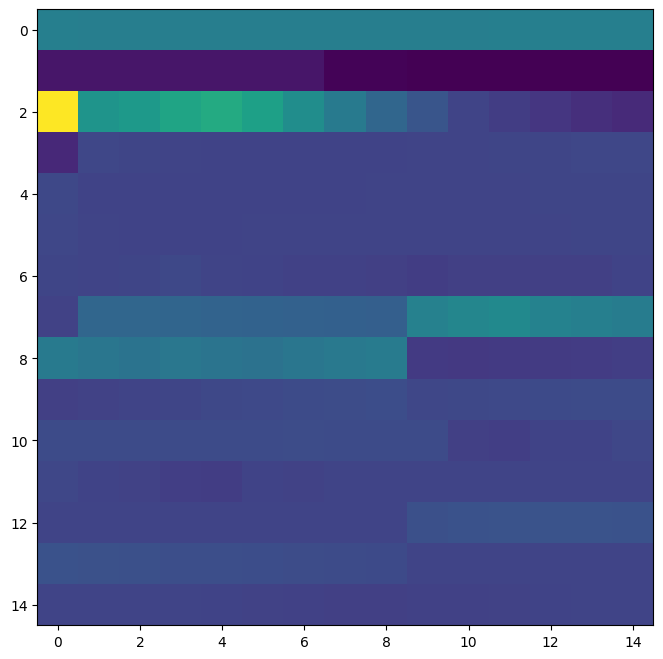

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))

plot_img = img[0]

plt. figure(figsize=(8, 8))
plt.imshow(plot_img)

In [ ]:
img = np.stack((img,)*3, axis=-1)
img.shape

(1, 15, 15, 3)

#Load CNN

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K

# load model
# model = load_model('models/cnn_best_model.h5', custom_objects={"f1_metric": f1_metric})
model = load_model('models/stock_cnn_best_model_selectedkbestfeatures_new_arch.h5')
# print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 20)        260       
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 20)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 40)          3240      
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 40)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dropout_5 (Dropout)         (None, 100)              

Test Prediction

In [ ]:
example_pred = model.predict(img)

prediction_label = np.argmax(example_pred, axis=1)
print(prediction_label)

1/1 [==============================] - 0s 26ms/step
[2]


# CNN Strategy

In [ ]:
class cnnPredictedAlgorithm(Strategy):

  def init(self):
    self.feat_data = self.data.df
    self.features_data = GetBestFeatureData(self.feat_data)

  def next(self):
    index = self.data.index
    size = len(index)
    last_i = index[-1]

    try:
      best_features = (self.features_data).loc[last_i] #get the best features from that day

      #reshape into a 2D array
      best_features_2d = np.array([best_features])

      img = best_features_2d.reshape(best_features_2d.shape[0], 15, 15)

      # expand to 3 channels
      img = np.stack((img,)*3, axis=-1)

      prediction_label = model.predict(img)

      prediction_label = np.argmax(prediction_label, axis=1)

    except:
      prediction_label = 0 #mark as hold if date is not found in df

    if prediction_label == 2:
      self.position.close()
      self.sell()

    elif prediction_label == 1:
      self.position.close()
      self.buy()


In [ ]:
algorithm = cnnPredictedAlgorithm
initial = 50000

cnn_bt = Backtest(bt_stock_df, algorithm, cash=initial)

###Backtester Output

In [ ]:
cnn_bt_output = cnn_bt.run()

1/1 [==============================] - 0s 31ms/step


In [ ]:
cnn_bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p4191', ...)

In [ ]:
trades = cnn_bt_output['_trades']

#PnL = trades['PnL'].sum()

return_amt = ((cnn_bt_output['Return [%]'] * 0.01) * initial)
print(f'Profit/Loss: {return_amt}')

Profit/Loss: 145409.83232879642


In [ ]:
cnn_bt_output

Start                     2020-01-02 00:00:00
End                       2024-05-08 00:00:00
Duration                   1588 days 00:00:00
Exposure Time [%]                   94.520548
Equity Final [$]                195409.832329
Equity Peak [$]                 232706.428642
Return [%]                         290.819665
Buy & Hold Return [%]               98.102228
Return (Ann.) [%]                   36.847121
Volatility (Ann.) [%]               50.261668
Sharpe Ratio                         0.733106
Sortino Ratio                        1.599901
Calmar Ratio                         1.251004
Max. Drawdown [%]                   -29.45403
Avg. Drawdown [%]                   -6.014452
Max. Drawdown Duration      287 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                  765
Win Rate [%]                        53.333333
Best Trade [%]                      16.740939
Worst Trade [%]                    -14.630374
Avg. Trade [%]                    

In [ ]:
cnn_bt_output['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-520,60,61,96.141502,98.217499,-1079.518127,-0.021593,2020-03-30,2020-03-31,1 days
1,-498,61,64,98.217499,95.557503,1324.678024,0.027083,2020-03-31,2020-04-03,3 days
2,525,64,65,95.557503,96.800003,652.312660,0.013003,2020-04-03,2020-04-06,3 days
3,525,65,69,96.800003,102.000000,2729.998398,0.053719,2020-04-06,2020-04-13,7 days
4,-525,69,70,102.000000,110.023499,-4212.336731,-0.078662,2020-04-13,2020-04-14,1 days
...,...,...,...,...,...,...,...,...,...,...
760,1101,1084,1085,179.940002,169.679993,-11296.270752,-0.057019,2024-04-24,2024-04-25,1 days
761,1101,1085,1086,169.679993,177.800003,8940.131424,0.047855,2024-04-25,2024-04-26,1 days
762,1101,1086,1087,177.800003,182.750000,5449.946640,0.027840,2024-04-26,2024-04-29,3 days
763,-1101,1087,1089,182.750000,181.639999,1222.110672,0.006074,2024-04-29,2024-05-01,2 days
